# How to add multi-turn conversation in a multi-agent application

!!! info "Prerequisites"
    This guide assumes familiarity with the following:

    - [How to implement handoffs between agents](../agent-handoffs)
    - [Multi-agent systems](../../concepts/multi_agent)
    - [Human-in-the-loop](../../concepts/human_in_the_loop)
    - [Command](../../concepts/low_level/#command)
    - [LangGraph Glossary](../../concepts/low_level/)


In this how-to guide, we’ll build an application that allows an end-user to engage in a *multi-turn conversation* with one or more agents. We'll create a node that uses an [`interrupt`](../../reference/types/#langgraph.types.interrupt) to collect user input and routes back to the **active** agent.

The agents will be implemented as nodes in a graph that executes agent steps and determines the next action:  

1. **Wait for user input** to continue the conversation, or  
2. **Route to another agent** (or back to itself, such as in a loop) via a [**handoff**](../../concepts/multi_agent/#handoffs).

```python
def human(state: MessagesState) -> Command[Literal["agent", "another_agent"]]:
    """A node for collecting user input."""
    user_input = interrupt(value="Ready for user input.")

    # Determine the active agent.
    active_agent = ...

    ...
    return Command(
        update={
            "messages": [{
                "role": "human",
                "content": user_input,
            }]
        },
        goto=active_agent
    )

def agent(state) -> Command[Literal["agent", "another_agent", "human"]]:
    # The condition for routing/halting can be anything, e.g. LLM tool call / structured output, etc.
    goto = get_next_agent(...)  # 'agent' / 'another_agent'
    if goto:
        return Command(goto=goto, update={"my_state_key": "my_state_value"})
    else:
        return Command(goto="human") # Go to human node
```

## Setup

First, let's install the required packages

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain-anthropic

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Define agents

In this example, we will build a team of travel assistant agents that can communicate with each other via handoffs.

We will create 2 agents:

* `travel_advisor`: can help with travel destination recommendations. Can ask `hotel_advisor` for help.
* `hotel_advisor`: can help with hotel recommendations. Can ask `travel_advisor` for help.

We will be using prebuilt [`create_react_agent`][langgraph.prebuilt.chat_agent_executor.create_react_agent] for the agents - each agent will have tools specific to its area of expertise as well as a special [tool for handoffs](../agent-handoffs#implementing-handoffs-using-tools) to another agent.

First, let's define the tools we'll be using:

In [3]:
import random
from typing import Annotated, Literal

from langchain_core.tools import tool
from langchain_core.tools.base import InjectedToolCallId
from langgraph.prebuilt import InjectedState


@tool
def get_travel_recommendations():
    """Get recommendation for travel destinations"""
    return random.choice(["aruba", "turks and caicos"])


@tool
def get_hotel_recommendations(location: Literal["aruba", "turks and caicos"]):
    """Get hotel recommendations for a given destination."""
    return {
        "aruba": [
            "The Ritz-Carlton, Aruba (Palm Beach)"
            "Bucuti & Tara Beach Resort (Eagle Beach)"
        ],
        "turks and caicos": ["Grace Bay Club", "COMO Parrot Cay"],
    }[location]


def make_handoff_tool(*, agent_name: str):
    """Create a tool that can return handoff via a Command"""
    tool_name = f"transfer_to_{agent_name}"

    @tool(tool_name)
    def handoff_to_agent(
        state: Annotated[dict, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
        """Ask another agent for help."""
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": tool_name,
            "tool_call_id": tool_call_id,
        }
        return Command(
            # navigate to another agent node in the PARENT graph
            goto=agent_name,
            graph=Command.PARENT,
            # This is the state update that the agent `agent_name` will see when it is invoked.
            # We're passing agent's FULL internal message history AND adding a tool message to make sure
            # the resulting chat history is valid.
            update={"messages": state["messages"] + [tool_message]},
        )

    return handoff_to_agent

Let's now create our agents using the the prebuilt [`create_react_agent`][langgraph.prebuilt.chat_agent_executor.create_react_agent]. We'll also define a dedicated `human` node with an [`interrupt`][langgraph.types.interrupt] -- we will route to this node after the final response from the agents. Note that to do so we're wrapping each agent invocation in a separate node function that returns `Command(goto="human", ...)`.

In [7]:
from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.prebuilt import create_react_agent, InjectedState
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver


model = ChatAnthropic(model="claude-3-5-sonnet-latest")


class MultiAgentState(MessagesState):
    last_active_agent: str


# Define travel advisor tools and ReAct agent
travel_advisor_tools = [
    get_travel_recommendations,
    make_handoff_tool(agent_name="hotel_advisor"),
]
travel_advisor = create_react_agent(
    model,
    travel_advisor_tools,
    prompt=(
        "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). "
        "If you need hotel recommendations, ask 'hotel_advisor' for help. "
        "You MUST include human-readable response before transferring to another agent."
    ),
)


def call_travel_advisor(
    state: MultiAgentState,
) -> Command[Literal["hotel_advisor", "human"]]:
    # You can also add additional logic like changing the input to the agent / output from the agent, etc.
    # NOTE: we're invoking the ReAct agent with the full history of messages in the state
    response = travel_advisor.invoke(state)
    update = {**response, "last_active_agent": "travel_advisor"}
    return Command(update=update, goto="human")


# Define hotel advisor tools and ReAct agent
hotel_advisor_tools = [
    get_hotel_recommendations,
    make_handoff_tool(agent_name="travel_advisor"),
]
hotel_advisor = create_react_agent(
    model,
    hotel_advisor_tools,
    prompt=(
        "You are a hotel expert that can provide hotel recommendations for a given destination. "
        "If you need help picking travel destinations, ask 'travel_advisor' for help."
        "You MUST include human-readable response before transferring to another agent."
    ),
)


def call_hotel_advisor(
    state: MultiAgentState,
) -> Command[Literal["travel_advisor", "human"]]:
    response = hotel_advisor.invoke(state)
    update = {**response, "last_active_agent": "hotel_advisor"}
    return Command(update=update, goto="human")


def human_node(
    state: MultiAgentState, config
) -> Command[Literal["hotel_advisor", "travel_advisor", "human"]]:
    """A node for collecting user input."""

    user_input = interrupt(value="Ready for user input.")
    active_agent = state["last_active_agent"]

    return Command(
        update={
            "messages": [
                {
                    "role": "human",
                    "content": user_input,
                }
            ]
        },
        goto=active_agent,
    )


builder = StateGraph(MultiAgentState)
builder.add_node("travel_advisor", call_travel_advisor)
builder.add_node("hotel_advisor", call_hotel_advisor)

# This adds a node to collect human input, which will route
# back to the active agent.
builder.add_node("human", human_node)

# We'll always start with a general travel advisor.
builder.add_edge(START, "travel_advisor")


checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

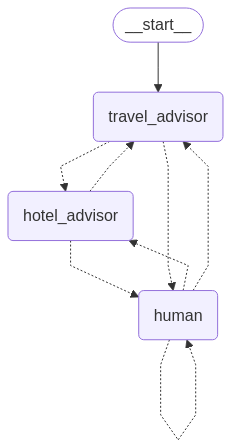

In [8]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

## Test multi-turn conversation

Let's test a multi turn conversation with this application.

In [9]:
import uuid

thread_config = {"configurable": {"thread_id": str(uuid.uuid4())}}

inputs = [
    # 1st round of conversation,
    {
        "messages": [
            {"role": "user", "content": "i wanna go somewhere warm in the caribbean"}
        ]
    },
    # Since we're using `interrupt`, we'll need to resume using the Command primitive.
    # 2nd round of conversation,
    Command(
        resume="could you recommend a nice hotel in one of the areas and tell me which area it is."
    ),
    # 3rd round of conversation,
    Command(
        resume="i like the first one. could you recommend something to do near the hotel?"
    ),
]

for idx, user_input in enumerate(inputs):
    print()
    print(f"--- Conversation Turn {idx + 1} ---")
    print()
    print(f"User: {user_input}")
    print()
    for update in graph.stream(
        user_input,
        config=thread_config,
        stream_mode="updates",
    ):
        for node_id, value in update.items():
            if isinstance(value, dict) and value.get("messages", []):
                last_message = value["messages"][-1]
                if isinstance(last_message, dict) or last_message.type != "ai":
                    continue
                print(f"{node_id}: {last_message.content}")


--- Conversation Turn 1 ---

User: {'messages': [{'role': 'user', 'content': 'i wanna go somewhere warm in the caribbean'}]}

travel_advisor: Based on the recommendations, Aruba would be an excellent choice for your Caribbean getaway! Aruba is known as "One Happy Island" and offers:
- Year-round warm weather with consistent temperatures around 82°F (28°C)
- Beautiful white sand beaches like Eagle Beach and Palm Beach
- Clear turquoise waters perfect for swimming and snorkeling
- Minimal rainfall and location outside the hurricane belt
- A blend of Caribbean and Dutch culture
- Great dining options and nightlife
- Various water sports and activities

Would you like me to get some specific hotel recommendations in Aruba for your stay? I can transfer you to our hotel advisor who can help with accommodations.

--- Conversation Turn 2 ---

User: Command(resume='could you recommend a nice hotel in one of the areas and tell me which area it is.')

hotel_advisor: Based on the recommendations,